In [5]:
import yfinance as yf
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Select an option:
1. Technical Analysis
2. Forecast
3. Trading Strategy Overview
4. Backtest Strategy

--- META - Forecast ---
Predicted Next Price: 720.26

Forecast Performance Metrics:
Mean Absolute Error (MAE): 7.02
Root Mean Squared Error (RMSE): 9.37
R² Score: 0.59

Price Forecast Visualization:


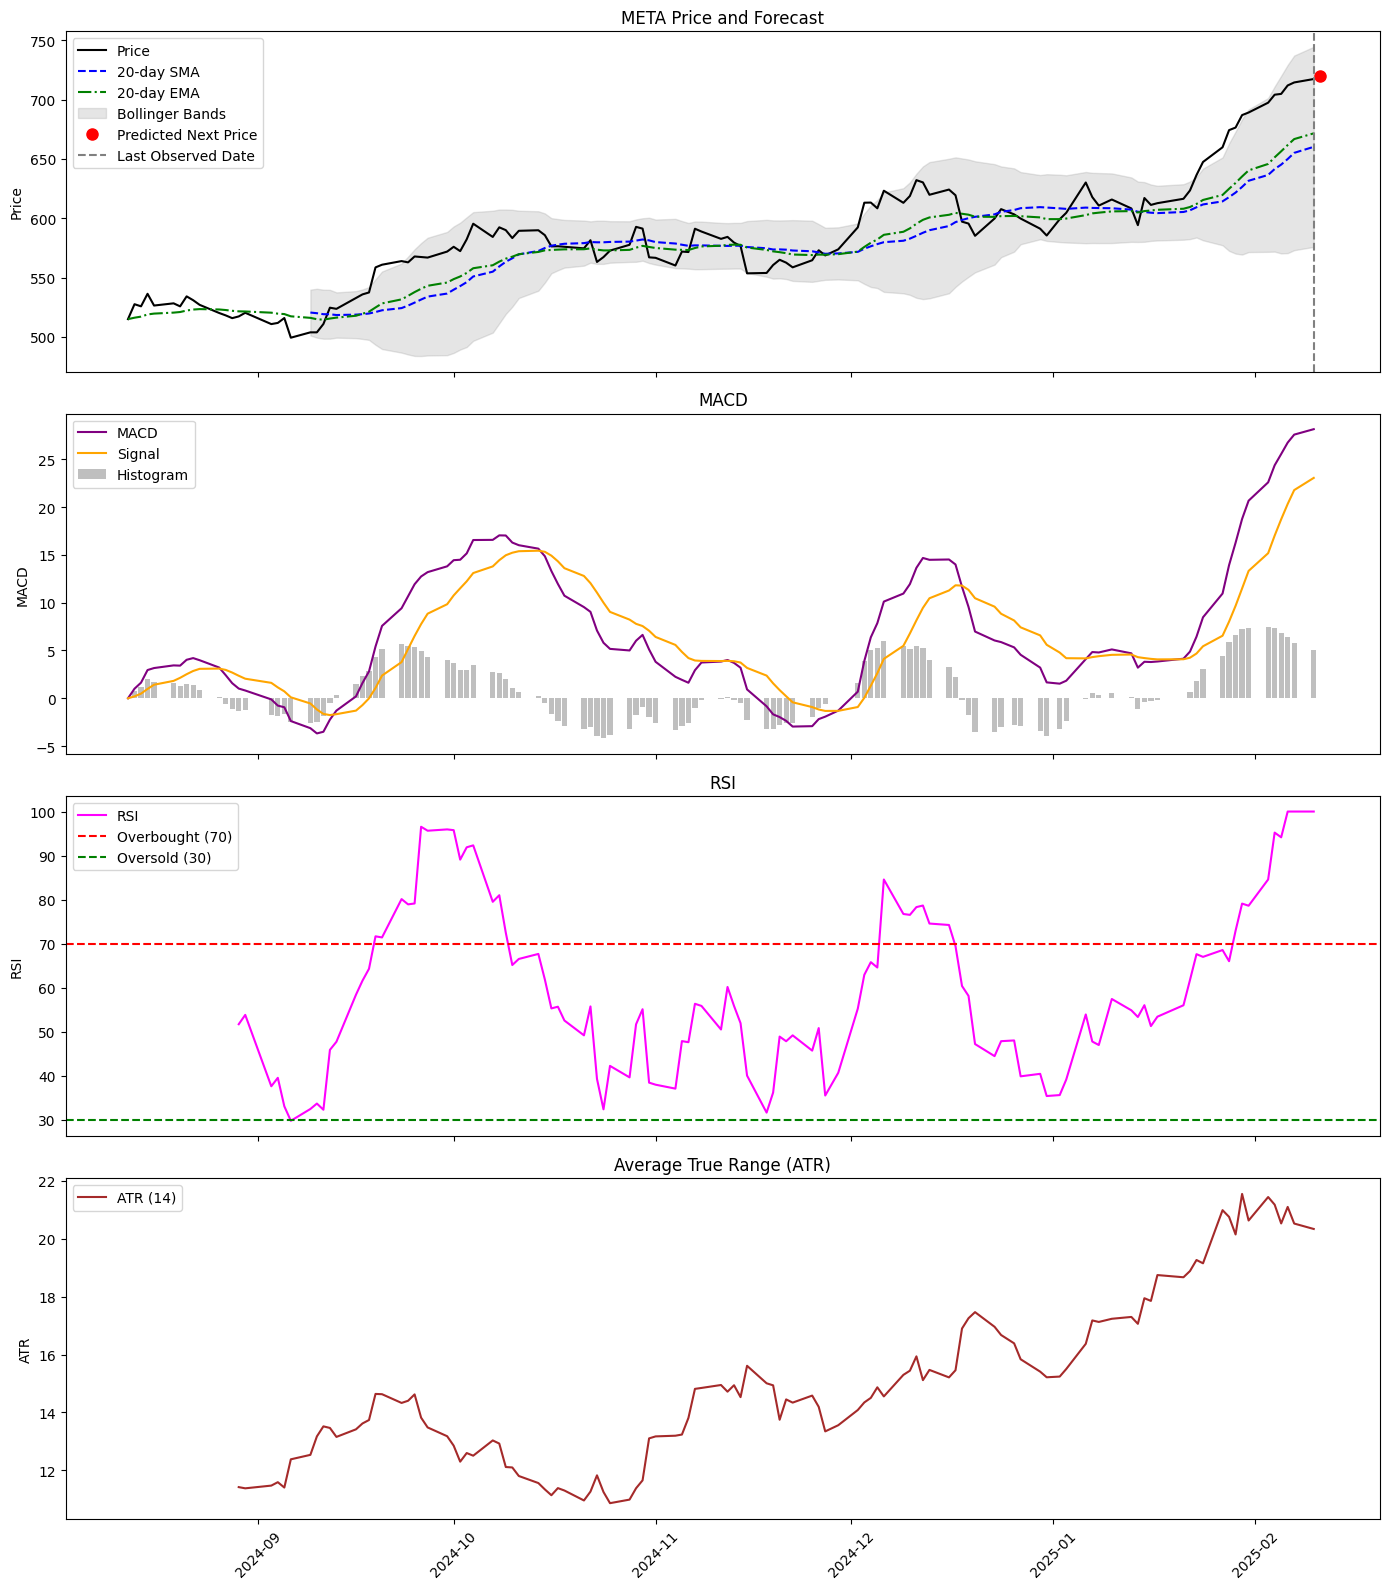

In [13]:
# Technical Indicator Functions
def compute_ATR(df, period=14):
    """
    Computes the Average True Range (ATR) for the DataFrame.
    Note: This function modifies the DataFrame in place by dropping helper columns.
    """
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    atr = df['TR'].rolling(window=period).mean()
    df.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)
    return atr

def compute_ATR_series(df, period=14):
    """
    Computes the ATR as a separate series without modifying the DataFrame.
    """
    hl = df['High'] - df['Low']
    hpc = abs(df['High'] - df['Close'].shift(1))
    lpc = abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([hl, hpc, lpc], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def compute_RSI(prices, period=14):
    """
    Computes the Relative Strength Index (RSI) for a Series of prices.
    """
    delta = prices.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# The forecast model
def forecast_next_close_ml(ticker):
    """
    Fetches 6 months of daily data and forecasts the next day’s price using XGBoost.
    Lag features include the previous 1 to 5 days’ closing prices.
    """
    stock = yf.Ticker(ticker)
    df = stock.history(period="6mo", interval="1d")
    if df.empty or len(df) < 60:
        return None

    # Create lag features (previous 1-5 days' closing prices)
    df['lag1'] = df['Close'].shift(1)
    df['lag2'] = df['Close'].shift(2)
    df['lag3'] = df['Close'].shift(3)
    df['lag4'] = df['Close'].shift(4)
    df['lag5'] = df['Close'].shift(5)
    df['rolling_mean_5'] = df['Close'].rolling(window=5).mean()
    df['rolling_std_5'] = df['Close'].rolling(window=5).std()
    df['RSI'] = compute_RSI(df['Close'], period=14)
    df['20d_SMA'] = df['Close'].rolling(window=20).mean()

    # Additional indicators
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    df['std20'] = df['Close'].rolling(window=20).std()
    df['Bollinger_width'] = (df['20d_SMA'] + 2 * df['std20'] - (df['20d_SMA'] - 2 * df['std20'])) / df['20d_SMA']
    df['ATR'] = compute_ATR(df.copy(), period=14)
    
    # Define the target as the next day’s price change
    df['target'] = df['Close'].shift(-1) - df['Close']
    features = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 
                'rolling_mean_5', 'rolling_std_5', 'RSI', '20d_SMA',
                'EMA20', 'MACD_hist', 'Bollinger_width', 'ATR']
    train_df = df.dropna(subset=features + ['target'])
    if train_df.empty:
        return None

    X_train = train_df[features]
    y_train = train_df['target']
    model = XGBRegressor(n_estimators=200, max_depth=5, random_state=42, verbosity=0)
    model.fit(X_train, y_train)
    
    valid_pred_df = df.dropna(subset=features)
    if valid_pred_df.empty:
        return None
    last_features = valid_pred_df.iloc[[-1]][features]
    last_price = valid_pred_df.iloc[-1]['Close']
    predicted_change = model.predict(last_features)[0]
    forecast = last_price + predicted_change
    return forecast

def forecast_for_df(df):
    """
    Similar to forecast_next_close_ml but uses the provided DataFrame.
    """
    if df.empty or len(df) < 60:
        return None
    df['lag1'] = df['Close'].shift(1)
    df['lag2'] = df['Close'].shift(2)
    df['lag3'] = df['Close'].shift(3)
    df['lag4'] = df['Close'].shift(4)
    df['lag5'] = df['Close'].shift(5)
    df['rolling_mean_5'] = df['Close'].rolling(window=5).mean()
    df['rolling_std_5'] = df['Close'].rolling(window=5).std()
    df['RSI'] = compute_RSI(df['Close'], period=14)
    df['20d_SMA'] = df['Close'].rolling(window=20).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    df['std20'] = df['Close'].rolling(window=20).std()
    df['Bollinger_width'] = (df['20d_SMA'] + 2 * df['std20'] - (df['20d_SMA'] - 2 * df['std20'])) / df['20d_SMA']
    df['ATR'] = compute_ATR(df.copy(), period=14)
    df['target'] = df['Close'].shift(-1) - df['Close']
    features = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 
                'rolling_mean_5', 'rolling_std_5', 'RSI', '20d_SMA',
                'EMA20', 'MACD_hist', 'Bollinger_width', 'ATR']
    train_df = df.dropna(subset=features + ['target'])
    if train_df.empty:
        return None
    X_train = train_df[features]
    y_train = train_df['target']
    model = XGBRegressor(n_estimators=200, max_depth=5, random_state=42, verbosity=0)
    model.fit(X_train, y_train)
    valid_pred_df = df.dropna(subset=features)
    if valid_pred_df.empty:
        return None
    last_features = valid_pred_df.iloc[[-1]][features]
    last_price = valid_pred_df.iloc[-1]['Close']
    predicted_change = model.predict(last_features)[0]
    return last_price + predicted_change

# Evaluating model performance
def compute_forecast_performance(ticker, test_period=10):
    stock = yf.Ticker(ticker)
    df = stock.history(period="6mo", interval="1d")
    if df.empty or len(df) < test_period + 30:
        return None
    errors = []
    for i in range(test_period, 0, -1):
        train_df = df.iloc[:-i].copy()
        actual = df['Close'].iloc[-i]
        forecast = forecast_for_df(train_df)
        if forecast is not None:
            errors.append(abs(actual - forecast))
    return np.mean(errors) if errors else None

def compute_forecast_performance_metrics(ticker, test_period=10):
    stock = yf.Ticker(ticker)
    df = stock.history(period="6mo", interval="1d")
    if df.empty or len(df) < test_period + 30:
        return None
    predictions, actuals = [], []
    for i in range(test_period, 0, -1):
        train_df = df.iloc[:-i].copy()
        actual = df['Close'].iloc[-i]
        forecast = forecast_for_df(train_df)
        if forecast is not None:
            predictions.append(forecast)
            actuals.append(actual)
    if len(predictions) == 0:
        return None
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = np.mean(np.abs(actuals - predictions))
    rmse = np.sqrt(np.mean((actuals - predictions) ** 2))
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else None
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Backtesting
def backtest_strategy(ticker, trade_amount=10000, start_date=None, end_date=None, confidence_threshold=1.0):
    """
    Backtests the trading strategy over the given time frame.
    
    The function:
      - Fetches data between start_date and end_date.
      - For each day (starting from index 60 for sufficient training data):
          * Retrains the model on data up to that day.
          * Computes the forecast and uses ATR to gauge the signal's strength.
          * The 'confidence' is defined as: 
                abs(forecast_price - current_price) / current_ATR.
          * A trade is only entered if the confidence exceeds confidence_threshold.
          * If forecast > current price, a long position is taken; otherwise, a short.
    
    Returns aggregated metrics (total profit, average ROI, win rate) and detailed trade data.
    """
    stock = yf.Ticker(ticker)
    if start_date and end_date:
        df = stock.history(start=start_date, end=end_date, interval="1d")
    else:
        df = stock.history(period="6mo", interval="1d")
    if df.empty or len(df) < 61:
        return None

    # Compute ATR series for the entire DataFrame.
    atr_series = compute_ATR_series(df, period=14)

    profits = []
    rois = []
    wins = 0
    total_trades = 0
    trades = []
    # Start backtesting from index 60 to ensure sufficient training data.
    for i in range(60, len(df) - 1):
        training_df = df.iloc[:i].copy()
        current_price = df.iloc[i]['Close']
        forecast_price = forecast_for_df(training_df)
        if forecast_price is None:
            continue
        actual_next = df.iloc[i+1]['Close']
        current_atr = atr_series.iloc[i]
        if np.isnan(current_atr) or current_atr == 0:
            continue
        # Define confidence as the absolute predicted change divided by ATR.
        confidence = abs(forecast_price - current_price) / current_atr
        if confidence < confidence_threshold:
            continue
        shares = trade_amount / current_price
        if forecast_price > current_price:
            profit = (actual_next - current_price) * shares  # Long position
        else:
            profit = (current_price - actual_next) * shares  # Short position
        roi = profit / trade_amount * 100
        profits.append(profit)
        rois.append(roi)
        total_trades += 1
        if profit > 0:
            wins += 1
        trades.append({
            "Date": df.index[i].strftime("%Y-%m-%d"),
            "Current Price": current_price,
            "Forecast": forecast_price,
            "Confidence": confidence,
            "Actual Next": actual_next,
            "Profit": profit,
            "ROI (%)": roi
        })
    total_profit = np.sum(profits) if profits else 0
    avg_roi = np.mean(rois) if rois else 0
    win_rate = wins / total_trades * 100 if total_trades > 0 else 0
    return {
        "Total Trades": total_trades,
        "Total Profit": total_profit,
        "Average ROI (%)": avg_roi,
        "Win Rate (%)": win_rate,
        "Trade Details": trades
    }

# Plots all indicators
def plot_all_indicators(ticker):
    stock = yf.Ticker(ticker)
    df = stock.history(period="6mo", interval="1d")
    if df.empty:
        return None

    forecast = forecast_next_close_ml(ticker)
    last_date = df.index[-1]
    next_date = last_date + pd.Timedelta(days=1)
    df['20d_SMA'] = df['Close'].rolling(window=20).mean()
    df['std20'] = df['Close'].rolling(window=20).std()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Upper_BB'] = df['20d_SMA'] + 2 * df['std20']
    df['Lower_BB'] = df['20d_SMA'] - 2 * df['std20']
    df['RSI'] = compute_RSI(df['Close'], period=14)
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    df['ATR'] = compute_ATR(df.copy(), period=14)

    # Prepare a copy for plotting the forecasted next price.
    df_forecast = df.copy()
    df_forecast.loc[next_date] = [np.nan] * (len(df.columns)-1) + [forecast]

    fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
    axs[0].plot(df.index, df['Close'], label='Price', color='black')
    axs[0].plot(df.index, df['20d_SMA'], label='20-day SMA', color='blue', linestyle='--')
    axs[0].plot(df.index, df['EMA20'], label='20-day EMA', color='green', linestyle='-.')
    axs[0].fill_between(df.index, df['Upper_BB'], df['Lower_BB'], color='gray', alpha=0.2, label='Bollinger Bands')
    axs[0].plot(next_date, forecast, 'ro', markersize=8, label='Predicted Next Price')
    axs[0].axvline(x=last_date, linestyle='--', color='gray', label='Last Observed Date')
    axs[0].set_title(f"{ticker} Price and Forecast")
    axs[0].set_ylabel("Price")
    axs[0].legend(loc='upper left')
    
    axs[1].plot(df.index, df['MACD'], label='MACD', color='purple')
    axs[1].plot(df.index, df['MACD_signal'], label='Signal', color='orange')
    axs[1].bar(df.index, df['MACD_hist'], label='Histogram', color='gray', alpha=0.5)
    axs[1].set_title("MACD")
    axs[1].set_ylabel("MACD")
    axs[1].legend(loc='upper left')
    
    axs[2].plot(df.index, df['RSI'], label='RSI', color='magenta')
    axs[2].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axs[2].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axs[2].set_title("RSI")
    axs[2].set_ylabel("RSI")
    axs[2].legend(loc='upper left')
    
    axs[3].plot(df.index, df['ATR'], label='ATR (14)', color='brown')
    axs[3].set_title("Average True Range (ATR)")
    axs[3].set_ylabel("ATR")
    axs[3].legend(loc='upper left')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig

#  So you can use in Jupyter notebook (i originally did this in a .py file)
def main():
    print("Select an option:")
    print("1. Technical Analysis")
    print("2. Forecast")
    print("3. Trading Strategy Overview")
    print("4. Backtest Strategy")
    
    option = input("Enter the number corresponding to your choice: ").strip()
    ticker = input("Enter ticker symbol (default AAPL): ").upper().strip() or "AAPL"
    
    if option == '1':
        print(f"\n--- {ticker} - Technical Analysis ---")
        fig = plot_all_indicators(ticker)
        if fig:
            plt.show()
        else:
            print("Unable to generate indicator visualization.")
    
    elif option == '2':
        print(f"\n--- {ticker} - Forecast ---")
        forecast_price = forecast_next_close_ml(ticker)
        if forecast_price:
            print(f"Predicted Next Price: {forecast_price:.2f}")
        else:
            print("Not enough data for forecasting.")
        print("\nForecast Performance Metrics:")
        metrics = compute_forecast_performance_metrics(ticker, test_period=10)
        if metrics is not None:
            print(f"Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
            print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
            print(f"R² Score: {metrics['R2']:.2f}")
        else:
            print("Insufficient data to compute forecast performance.")
        print("\nPrice Forecast Visualization:")
        fig = plot_all_indicators(ticker)
        if fig:
            plt.show()
        else:
            print("Unable to generate forecast visualization.")
    
    elif option == '3':
        print("\n--- Trading Strategy Overview ---")
        print("""
This strategy integrates an XGBoost-based ML forecast with traditional technical analysis.

Key Elements:
- Forecasting: The model predicts the next-day price change using lag features (previous 1–5 days’ closing prices) and technical indicators (moving averages, RSI, MACD histogram, Bollinger Band width, ATR).
- Technical Confirmation: Traditional indicators help confirm trends and momentum.
- Trade Signal: A long position is taken if the forecast exceeds the current price; otherwise, a short position is assumed.
- Risk Management: Volatility (via ATR) is used to gauge signal strength.
        """)
        print("Implementation Details:")
        print("""
1. Data is fetched from Yahoo Finance (currently up to 6 months).
2. Features include lag prices (previous 1–5 days) and various technical indicators.
3. XGBoost (XGBRegressor) forecasts the next-day price change.
4. Trade signals are generated by comparing the forecasted price with the current price.
5. A trade is only entered if the forecast’s confidence (signal-to-volatility ratio) exceeds a set threshold.
        """)
        print("Conclusion:")
        print("This strategy leverages XGBoost to capture complex market dynamics and, combined with technical analysis, offers robust trading signals when the model’s confidence is high.")
    
    elif option == '4':
        print("\n--- Backtest Strategy ---")
        default_start = (datetime.date.today() - datetime.timedelta(days=180)).strftime("%Y-%m-%d")
        default_end = datetime.date.today().strftime("%Y-%m-%d")
        start_date = input(f"Enter Backtest Start Date (YYYY-MM-DD, default {default_start}): ").strip() or default_start
        end_date = input(f"Enter Backtest End Date (YYYY-MM-DD, default {default_end}): ").strip() or default_end
        trade_amount_input = input("Enter Trade Amount ($, default 10000): ").strip() or "10000"
        confidence_input = input("Enter Confidence Threshold (default 1.0): ").strip() or "1.0"
        # Convert inputs to appropriate types
        trade_amount = float(trade_amount_input)
        confidence_threshold = float(confidence_input)
        
        results = backtest_strategy(ticker, trade_amount, start_date, end_date, confidence_threshold)
        if results is not None:
            print("\nBacktest Results:")
            print(f"Total Trades: {results['Total Trades']}")
            print(f"Total Profit: ${results['Total Profit']:.2f}")
            print(f"Average ROI: {results['Average ROI (%)']:.2f}%")
            print(f"Win Rate: {results['Win Rate (%)']:.2f}%")
            print("\nTrade Details:")
            trades_df = pd.DataFrame(results["Trade Details"])
            print(trades_df)
        else:
            print("Insufficient data to perform backtest.")
    
    else:
        print("Invalid option. Please run the cell again and choose a valid option.")

# -------------------------------
# Run the main function
# -------------------------------
if __name__ == '__main__':
    main()


In [14]:
main() #this output is for a confidence level of 0.1 (low)

Select an option:
1. Technical Analysis
2. Forecast
3. Trading Strategy Overview
4. Backtest Strategy

--- Backtest Strategy ---

Backtest Results:
Total Trades: 53
Total Profit: $344.88
Average ROI: 0.07%
Win Rate: 49.06%

Trade Details:
          Date  Current Price    Forecast  Confidence  Actual Next  \
0   2024-11-07     591.223145  583.223332    0.539974   588.865051   
1   2024-11-08     588.865051  593.715998    0.326722   582.699951   
2   2024-11-11     582.699951  587.166986    0.298825   584.348633   
3   2024-11-12     584.348633  576.766912    0.515103   579.532532   
4   2024-11-14     576.694824  574.966377    0.118960   553.633423   
5   2024-11-15     553.633423  574.827020    1.357547   553.953186   
6   2024-11-18     553.953186  550.800935    0.210040   560.637817   
7   2024-11-19     560.637817  557.878105    0.184754   565.064209   
8   2024-11-20     565.064209  567.973444    0.211586   562.636169   
9   2024-11-21     562.636169  572.031077    0.650080   558.6

In [15]:
main() # this is for a higher confidence level (1.0) for the same stock

Select an option:
1. Technical Analysis
2. Forecast
3. Trading Strategy Overview
4. Backtest Strategy

--- Backtest Strategy ---

Backtest Results:
Total Trades: 10
Total Profit: $505.46
Average ROI: 0.51%
Win Rate: 70.00%

Trade Details:
         Date  Current Price    Forecast  Confidence  Actual Next      Profit  \
0  2024-11-15     553.633423  574.827020    1.357547   553.953186    5.775720   
1  2024-11-22     558.689392  579.714567    1.466132   564.654541  106.770399   
2  2024-12-03     613.155457  593.727469    1.354150   613.285339   -2.118269   
3  2024-12-06     623.267273  602.656394    1.416099   613.075500  163.521701   
4  2024-12-11     632.170044  615.990098    1.015234   630.281555   29.873114   
5  2024-12-13     619.849976  638.449142    1.202299   624.239990   70.823825   
6  2024-12-18     597.190002  617.533063    1.203847   595.570007  -27.126963   
7  2024-12-23     599.849976  577.273678    1.331367   607.750000 -131.700004   
8  2025-01-06     630.200012  60